# Delivery Data Cleansing

Environment: Python 3.7 and Jupyter notebook

Libraries used:
- pandas (for dataframe, included in Anaconda 3.7) 
- dataclass (for `dataclass` decorator, included in Python 3.7)
- typing (for type notation, included in Python 3.7)
- functools (for `reduce()` to reduce process, included in Python 3.7)
- itertools (for `groupby()` to implement `reduce_by_key()`, included in Python 3.7)
- matplotlib (for box and bar chart plot, incluede in Anaconda 3.7)
- statistics (for `mode()` to calculate mode in dataset, included in Python 3.7)
- networkx (for solve graph problem with dijkstra algorithm, included in Anaconda 3.7)
- datetime (for datetime manipulation, included in Python 3.7)
- sklearn (for fitting linear model, included in Python 3.7)
- tqdm (for display progress bar, downloaded from pip)

# 1. Introduction

Exploring and understanding the data is one of the most important parts of the data wrangling
process. 

This project is aim to:
- Detect and fix errors in `dirty_data.csv`
- Detect and remove outlier rows in `outlier_data.csv` (outliers are to be found w.r.t. delivery_fee attribute)
- Impute the missing values in `missing_data.csv`


# 2. Import libraries

In [1]:
import pandas as pd
from dataclasses import dataclass
from typing import List
from pandas.core.series import Series
from functools import reduce
from itertools import groupby
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode
import networkx as nx
from networkx.algorithms.shortest_paths import dijkstra_path_length
from datetime import datetime
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

# 3. Load nodes and branches

In order to caculate the distance between customers and branches, the nodes of brahces and customers are necessary. Therefore, this part is aimed to make a nodes related dataframe which will be used in part 4.3.1.

In addition, the branch nodes are not given, so we need transfer the lat and lon infomation in branches.csv to a branch node based on the all nodes dataframe (created in 3.1)

## 3.1 Create Node class

Define a Node class to store all nodes information inside.

The Node class contains the methods:
- __init__(): constructor of Node class
- build_node(): a static method to build the Node instances
- __repr__(): a method to display Node instances

In [2]:
# define the class Node to store node info from the csv file
class Node:
    node_list = []
    
    def __init__(self, node_id, lat, lon):
        self.node_id = node_id
        self.lat = lat
        self.lon = lon
        # insert each node into the node_list
        Node.node_list.append(self)
    
    # define the static method to build node instances from each row in data frame
    @staticmethod
    def build_node(row):
        node_id = row[0]
        lat = round(row[1], 7) # get lat from the node_data
        lon = round(row[2], 7) # get lon from the node_data
        return Node(node_id, lat, lon)
    
    # define __repr__ method for better representation
    def __repr__(self):
        return f"<Node {self.node_id} at ({self.lat}, {self.lon})>"

Load the `nodes.csv` as data frame.

In [3]:
node_data = pd.read_csv("nodes.csv")
node_data.head(3)

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817


In [4]:
node_data.dtypes

node      int64
lat     float64
lon     float64
dtype: object

In [5]:
# build Node intances from each row in the data frame
for row in node_data.values:
    Node.build_node(row)

Node.node_list[:10]

[<Node 711327755.0 at (-37.807675, 144.9558726)>,
 <Node 711327756.0 at (-37.8070943, 144.9559785)>,
 <Node 711327759.0 at (-37.8073009, 144.9578172)>,
 <Node 711327760.0 at (-37.8078848, 144.9577193)>,
 <Node 777781264.0 at (-37.8052207, 144.9521732)>,
 <Node 711327758.0 at (-37.8062498, 144.9580023)>,
 <Node 164102232.0 at (-37.8203223, 144.9675308)>,
 <Node 26476632.0 at (-37.8227347, 144.9311156)>,
 <Node 26476637.0 at (-37.8262913, 144.930619)>,
 <Node 26476642.0 at (-37.8262801, 144.9307411)>]

## 3.2 Load branch data and get the branch node

Define a BranchLocation class to store all information of each branch.

The BranchLocation contains methods:
- __init__(): the constructor 
- build_branch_location(): the static method to build BranchLocation method from the row of data frame
- find_node(): the method to find a related node from node objects
- __repr__(): the method to display the information about the node and location of this branch

In [6]:
# define the class to store the information for each branch
class BranchLocation:
    branch_loc_list = []
    
    def __init__(self, branch_code, branch_lat, branch_lon):
        self.branch_code = branch_code
        self.branch_lat = branch_lat
        self.branch_lon = branch_lon
        # find the node for the location of the branch
        self.node = self.find_node()
        # store each intance into the list
        BranchLocation.branch_loc_list.append(self)
    
    @staticmethod
    def build_branch_location(row):
        branch_code = row[0]
        branch_lat = round(row[2], 7)
        branch_lon = round(row[3], 7)
        return BranchLocation(branch_code, branch_lat, branch_lon)
    
    def find_node(self):
        for node in Node.node_list:
            if node.lat == self.branch_lat and node.lon == self.branch_lon:
                return node.node_id
    
    def __repr__(self):
        return f"<BranchLocation {self.branch_code} at Node {self.node} with ({self.branch_lat}, {self.branch_lon})>"

Load the data in `branches.csv` as data frame.

In [7]:
branch_data = pd.read_csv("branches.csv")
branch_data.head()

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


In [8]:
# build object for each row in data frame
for row in branch_data.values:
    BranchLocation.build_branch_location(row)

BranchLocation.branch_loc_list

[<BranchLocation NS at Node 2455254505.0 with (-37.7738026, 144.9836466)>,
 <BranchLocation TP at Node 1390575046.0 with (-37.8618349, 144.905716)>,
 <BranchLocation BK at Node 1889485053.0 with (-37.8158343, 145.04645)>]

# 4. Dirty data
## 4.1 Examining and loading data

Load dirty data in `dirty_data.csv` as data frame.

In [9]:
dirty_data = pd.read_csv("dirty_data.csv")

In [10]:
dirty_data.head(3)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA09604,2018-06-15,13:24:30,Lunch,BK,"[('Fries', 6), ('Burger', 6), ('Chicken', 9), ...",943.0,-37.801805,144.957119,0,8.207,14.143094
1,ORDI01219,2018-01-03,08:00:00,Breakfast,NS,"[('Pancake', 6), ('Coffee', 3), ('Cereal', 6),...",404.0,-37.813730,144.940948,1,9.632,7.495310
2,ORDC00455,2018-02-19,09:31:16,Breakfast,NS,"[('Coffee', 2), ('Pancake', 10), ('Eggs', 9)]",455.5,37.805031,144.927906,0,10.574,15.722936


In [11]:
dirty_data.shape

(500, 12)

There are 12 columns and 500 rows in our data.

## 4.2 Classify features

In [12]:
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


### 4.2.1 Categorical Features & Numerical Features
Categorical variable: order_id, date, time, order_type, branch_code, oder_item, customerHasloyalty?   
Odinal variable:
Continuous numerical:delivery_fee, distance_to_customer_KM, customer_lon, customer_lat, order_price 


### 4.2.2 Distribution of numerical values


In [13]:
dirty_data.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,475.540000,-30.754010,143.502178,0.112000,8.628968,13.830413
std,259.230361,25.337001,16.299209,0.315682,1.481894,2.336370
min,43.500000,-37.828450,-37.825348,0.000000,3.615000,5.240995
25%,278.750000,-37.817971,144.950196,0.000000,7.769750,12.526529
50%,416.250000,-37.811948,144.962027,0.000000,8.636000,13.994416
75%,627.062500,-37.805667,144.976975,0.000000,9.647250,15.348252
max,1298.000000,145.001910,145.016324,1.000000,12.752000,19.243625


The observation tells us that:

* The total order amount is 500
* Customers have loyalty card or not is a categorical feature with 0 or 1 values.


In [14]:
dirty_data.describe(include=['O'])

,order_id,date,time,order_type,branch_code,order_items
count,500,500,500,500,500,500
unique,500,301,71,3,6,496
top,ORDA09604,2018-07-08,11:32:57,Lunch,BK,"[('Steak', 2), ('Chicken', 3)]"
freq,1,6,13,177,171,2


The values in order_items are lists, which contains the items and the quantity of them.

In [15]:
eval(dirty_data.values[0].tolist()[5])

[('Fries', 6), ('Burger', 6), ('Chicken', 9), ('Steak', 5), ('Salad', 10)]

## 4.3 Preparation for creating data objects

Based on 4.1, we find that customer_lat, customer_lon, delivery_fee are
Keeping 7 decimal places and distance_to_customer_KM keeps 3 demicial places. 

When the computer read the data from csv files, it will get the tiny difference from the original one, because all values stored in computer is binary, and binary cannot represent all decimal floats so there will be some proximity values.

In [16]:
# extract values as preparation to build data object
def extract_values_from_row(row: Series) -> List:
    # generate a value list from the row in data frame
    values = row.tolist()
    values[7] = round(values[7], 7)
    values[8] = round(values[8], 7)
    values[10] = round(values[10], 3)
    values[11] = round(values[11], 7)
    # as the order_items is string, using list to format it is easier to process
    # eval function is for extracting the string content
    # for the order_items here, it convert the string to list
    values[5] = eval(values[5])
    return values

### 4.3.1  Build a Data class as parent class

The Following `DirtyData class`(4.3.2), `OutlierData class`(5.1) and `MissingData class`(6.2) will inherit the Data class.
In order to simplify the initialization of Data class, here, we used a @dataclass(Python, 2019).

As the code of methods of this class can only be written in the class, here only introduce briefly to these methods. As for the details of these methods, please refer to the below sections.

The Data class has these methods:
- day(): a property for fitting linear model, and will be introduced in 5.2
- features(): a property for fitting linear model, and will be introduced in 5.2
- build_data_from_row(): a static method to build Data objects from a given row in data frame.
- to_list(): a method to transfer the attributes of the instance to a list as preparation of building a data frame
- get_header(): a static method to get the data frame header for Data objects
- find_node(): a similar method to the BranchLocation one, to find the related node in the node data, and will be introduced in 4.4.5
- find_branch_node(): a similar method to `find_node()`. This is to find the branch node for the order.
- find_branch_code(): a method to find correct branch code from `order_id`, and will be introduced in 4.4.3
- fee(): a property for calculate the actual fee without loyalty discount, and will be introduced in 5.2

In [17]:
# define Data class to store data for each row in data frame
@dataclass
class Data:
    order_id: str
    date: str
    time: str
    order_type: str
    branch_code: str
    order_items: List
    order_price: float
    customer_lat: float
    customer_lon: float
    customerHasloyalty: int
    distance_to_customer_KM: float
    delivery_fee: float
        
    # define the day for calculate the linear model
    @property
    def day(self):
        # Monday is 0 and Sunday is 6
        return datetime.strptime(self.date, "%Y-%m-%d").date().weekday()
    
    # define the function to create a feature vector for fitting linear model
    @property
    def features(self):
        time_map = {
            "Breakfast": 0,
            "Lunch": 1,
            "Dinner": 2
        }
        # if day is weekday, day_feature is 0;
        # if day is weekend, day_feature is 1
        day_feature = 0 if self.day <= 4 else 1
        time_feature = time_map[self.order_type]
        distance_feature = self.distance_to_customer_KM
        return day_feature, time_feature, distance_feature
        
    @staticmethod
    def build_data_from_row(row: Series):
        values = extract_values_from_row(row)
        return Data(*values)
    
    # transfer the instance to a list for building data frame
    def to_list(self):
        return [
            self.order_id,
            self.date,
            self.time,
            self.order_type,
            self.branch_code,
            self.order_items,
            self.order_price,
            self.customer_lat,
            self.customer_lon,
            self.customerHasloyalty,
            self.distance_to_customer_KM,
            self.delivery_fee
        ]
    
    # return a csv header for output
    @staticmethod
    def get_header():
        return dirty_data.columns.tolist()
    
    # find the node for each order location
    def find_node(self):
        for node in Node.node_list:
            if node.lat == self.customer_lat and node.lon == self.customer_lon:
                return node.node_id
    
    # find the branch node which the customer ordered
    def find_branch_node(self):
        for branch in BranchLocation.branch_loc_list:
            if branch.branch_code == self.branch_code:
                return branch.node
    
    # from the order_id to find correct branch code
    def find_branch_code(self):
        id_head = self.order_id[:4]
        for branch, id_set in id_map.items():
            if id_head in id_set:
                return branch
            
    def get_order_items(self):
        return self.order_items
    
    @property
    def fee(self):
        if self.customerHasloyalty:
            return self.delivery_fee * 2
        else:
            return self.delivery_fee

### 4.3.2 Create DirtyData class to Inheritance Class Data
The following DirtyData class will inherit the Data Class in 4.3.1

Based on the following part EDA, we konw that there are many errors in the dirty data. Therefore, methods for fixing data, order_type, branch_code, order_items, order_price, location, distance and customerHasloyalty are defined here.

The DirtyData class contains the methods:
- __init__(): the contructor of this class
- build_data_from_row(): a static method of building a DirtyData instance from a row of data frame
- fix_date(): a method to fix date, and will be introduced in 4.4.1
- fix_order_type(): a method to fix order_type, and will be introduced in 4.4.2
- fix_branch_code(): a method to fix branch_code, and will be introduced in 4.4.3
- fix_order_items(): a method to fix order_items, and will be introduced in 4.4.4
- fix_order_price(): a method to fix order_price, and will be introduced in 4.4.4
- fix_location(): a method to fix location, and will be introduced in 4.4.5
- fix_distance(): a method to fix distance, and will be introduced in 4.4.5
- display_loc(): a method to display location, and will be introduced in 4.4.5
- fix_customerHasloyalty(): a method to fix loyalty, and will be introduced in 5.2.1

In [18]:
# define a variable to store Data objects
dirty_data_list = []

# define the dirty data class for manipulating the dirty data
class DirtyData(Data):
    def __init__(self, *args):
        Data.__init__(self, *args)
        self.node = self.find_node()
        self.branch_node = self.find_branch_node()
        dirty_data_list.append(self)
    
    @staticmethod
    def build_data_from_row(row: Series):
        values = extract_values_from_row(row)
        return DirtyData(*values)
    
    # define the method for fixing the date
    def fix_date(self):
        # split the data to 3 numbers 
        n1, n2, n3 = self.date.split("-")
        # if the third number is 4-digit, it means it is year and need to be fixed
        if len(n3) == 4:
            self.date = "-".join([n3, n2, n1])
        # if the month number is larger than 12, it means the locations of month and day are reversed
        elif int(n2) > 12:
            self.date = "-".join([n1, n3, n2])
        return self
    
    def fix_order_type(self):
        # get correct order_type from the time
        classified_type = classify_order_type(self.time)
        if classified_type != self.order_type:
            self.order_type = classified_type
        return self
    
    def fix_branch_code(self):
        is_changed = False
        # fix the uppercase and lowercase issue first
        branch_code_replace_map = {'tp':'TP', 'ns':'NS', 'bk':'BK'}
        if self.branch_code in branch_code_replace_map:
            self.branch_code = branch_code_replace_map[self.branch_code]
            is_changed = True
        # find correct branch from order_id
        correct_branch = self.find_branch_code()
        if self.branch_code != correct_branch:
            self.branch_code = correct_branch
            is_changed = True
        # if the branch code is fixed, re-find the branch node
        if is_changed:
            self.branch_node = self.find_branch_node()
        return self

    def fix_order_items(self):
        correct_menu_map = {
            "Breakfast": BREAKFAST_PRICE,
            "Lunch": LUNCH_PRICE,
            "Dinner": DINNER_PRICE
        }
        is_correct = True
        correct_price = correct_menu_map[self.order_type]
        # check if there is wrong item in the order_items
        for item, quantity in self.order_items:
            if item not in correct_price:
                is_correct = False
                break
        # if the order_items is correct, do nothing
        if is_correct:
            return self
        # else fix the wrong item
        else:
            new_order_items = self.order_items.copy()
            # initialize the price variable for calculation
            price = self.order_price
            # minus all correct item prices
            for item, quantity in self.order_items:
                if item in correct_price:
                    price -= correct_price[item] * quantity
            # get the wrong item and index
            wrong_pair = list(filter(lambda x: x[0] not in correct_price.keys(), self.order_items))[0]
            wrong_index = new_order_items.index(wrong_pair)
            # calculate the correct price for the wrong item
            correct_item_price = price / wrong_pair[1]
            # find the correct item from menu
            for menu_item, menu_price in correct_price.items():
                if menu_price == correct_item_price:
                    correct_item = menu_item
                    break
            # modify the wrong pair to correct one
            new_order_items[wrong_index] = (correct_item, wrong_pair[1])
            self.order_items = new_order_items
            return self
        
    def fix_order_price(self):
        # calculate the correct price from the correct order_items
        # fix the order_price if it is not equal
        correct_menu_map = {
            "Breakfast": BREAKFAST_PRICE,
            "Lunch": LUNCH_PRICE,
            "Dinner": DINNER_PRICE
        }
        correct_price = correct_menu_map[self.order_type]
        price = 0
        for item, quantity in self.order_items:
            price += correct_price[item] * quantity
        price = round(price, 2)

        if price != self.order_price:
            self.order_price = price
        return self
    
    def fix_location(self):
        if 30 < self.customer_lat < 40:
            # if the error is the negative sign
            self.customer_lat = self.customer_lat * (-1)
            self.node = self.find_node()
            return self
        elif self.customer_lat > 100 and self.customer_lon < 0:
            # if the error is the opposite places of lat and lon values
            self.customer_lat, self.customer_lon = self.customer_lon, self.customer_lat
            self.node = self.find_node()
            return self
        else:
            # no fix for no error rows
            return self
        
    def fix_distance(self):
        # calculate the distance by dijkstra algorithm
        distance = dijkstra_path_length(G=graph, source=self.branch_node, target=self.node, weight="distance")
        # transfer m to km
        distance /= 1000
        if distance != self.distance_to_customer_KM:
            self.distance_to_customer_KM = distance
        return self
        
    def display_loc(self):
        # display customer location node
        return f"Node {self.node} in ({self.customer_lat}, {self.customer_lon})"
    
    def fix_customerHasloyalty(self):
        predicted_loyalty = predict_loyalty(self)
        if self.customerHasloyalty != predicted_loyalty:
            self.customerHasloyalty = predicted_loyalty
        return self

## 4.4 Fixing Errors

### 4.4.1 Fix date

In [19]:
dirty_data.tail(12)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
488,ORDB01761,2018-12-23,19:49:51,Dinner,TP,"[('Fish&Chips', 3), ('Pasta', 1), ('Salmon', 7)]",419.5,-37.816492,144.945971,0,7.816,14.779643
489,ORDY00571,2018-19-07,14:35:29,Lunch,TP,"[('Burger', 3), ('Steak', 9)]",498.0,-37.799380,144.973005,0,10.231,13.634579
490,ORDC05278,11-10-2018,17:17:44,Dinner,NS,"[('Pasta', 7), ('Fish&Chips', 5), ('Salmon', 7)]",654.5,-37.812124,144.953429,0,8.452,14.611985
491,ORDB05798,2018-09-07,16:16:54,Dinner,TP,"[('Salmon', 1), ('Fish&Chips', 1)]",76.0,37.819890,144.976928,0,8.498,12.451754
492,ORDA04457,2018-02-07,09:10:59,Breakfast,BK,"[('Pancake', 2), ('Cereal', 9), ('Eggs', 8)]",413.5,-37.819275,144.965030,0,7.791,12.522506
493,ORDA05709,2018-12-19,19:39:43,Dinner,BK,"[('Fish&Chips', 8), ('Shrimp', 9)]",766.0,-37.814337,144.935910,0,9.227,17.030775
494,ORDZ10367,2018-05-28,12:54:05,Lunch,NS,"[('Chicken', 10), ('Fries', 1)]",332.0,-37.815067,144.973538,0,8.026,13.595156
495,ORDJ07108,2018-06-18,13:34:38,Lunch,TP,"[('Steak', 2), ('Fries', 9), ('Chicken', 5)]",358.0,-37.813254,144.973865,0,8.625,12.518367
496,ORDJ00204,2018-09-15,16:27:02,Breakfast,TP,"[('Salmon', 10), ('Pasta', 6)]",575.0,-37.809799,144.991895,0,10.314,15.651098
497,ORDI09933,2018-01-20,08:30:25,Breakfast,NS,"[('Eggs', 10), ('Pancake', 8)]",414.0,-37.799101,144.933486,1,9.514,17.130792


Based on the above result, we find that there are two types of error in terms of the date:

1. The data use dd-mm-YYYY not YYYY-mm-dd
2. The place of month and day in wrong place

Then, we find all errors at following cell.

In [20]:
for each in dirty_data.date:
    if len(each.split("-")[2]) == 4 or int(each.split('-')[1]) > 12:
        print(each)

08-10-2018
09-09-2018
2018-17-07
2018-30-07
12-10-2018
2018-30-08
2018-16-10
2018-16-06
2018-13-11
09-12-2018
2018-24-03
2018-26-04
08-01-2018
09-12-2018
2018-13-05
2018-28-07
06-06-2018
2018-29-08
12-02-2018
2018-18-02
01-12-2018
10-01-2018
09-02-2018
04-04-2018
2018-29-01
11-11-2018
07-01-2018
2018-24-02
2018-28-02
2018-26-10
2018-13-12
2018-27-01
2018-28-03
05-06-2018
2018-22-03
2018-19-07
11-10-2018


Count the numbers of dirty data with wrong date.

In [21]:
count = 0
for each in dirty_data.date:
    if len(each.split("-")[2]) == 4 or int(each.split("-")[1]) > 12:
        count += 1
count

37

The fix_date method is used here to fix all date errors.
This method was defined in DirtyData class <b>(4.3.2)</b >
The method is defined as following:

```python
    # define the method for fixing the date
    def fix_date(self):
        # split the data to 3 numbers 
        n1, n2, n3 = self.date.split("-")
        # if the third number is 4-digit, it means it is year and need to be fixed
        if len(n3) == 4:
            self.date = "-".join([n3, n2, n1])
        # if the month number is larger than 12, it means the locations of month and day are reversed
        elif int(n2) > 12:
            self.date = "-".join([n1, n3, n2])
        return self
```

In [22]:
# generate dirty data instances from rows in data frame
dirty_data_list = []
for row in dirty_data.values:
    DirtyData.build_data_from_row(row)
dirty_data_list[:2]

[DirtyData(order_id='ORDA09604', date='2018-06-15', time='13:24:30', order_type='Lunch', branch_code='BK', order_items=[('Fries', 6), ('Burger', 6), ('Chicken', 9), ('Steak', 5), ('Salad', 10)], order_price=943.0, customer_lat=-37.8018052, customer_lon=144.9571189, customerHasloyalty=0, distance_to_customer_KM=8.207, delivery_fee=14.1430936),
 DirtyData(order_id='ORDI01219', date='2018-01-03', time='08:00:00', order_type='Breakfast', branch_code='NS', order_items=[('Pancake', 6), ('Coffee', 3), ('Cereal', 6), ('Eggs', 5)], order_price=404.0, customer_lat=-37.8137302, customer_lon=144.9409476, customerHasloyalty=1, distance_to_customer_KM=9.632, delivery_fee=7.4953104)]

<b> The following method is defined in Data Class </b>
```python
    @staticmethod
    def build_data_from_row(row: Series):
        values = extract_values_from_row(row)
        return Data(*values)
```
<b> extract_values_from_row( ) will be called in build_data_from_row( ) which is used to construct attributes for class</b>
```python
# extract values as preparation to build data object
def extract_values_from_row(row: Series) -> List:
    # generate a value list from the row in data frame
    values = row.tolist()
    values[7] = round(values[7], 7)
    values[8] = round(values[8], 7)
    values[10] = round(values[10], 3)
    values[11] = round(values[11], 7)
    # as the order_items is string, using list to format it is easier to process
    # eval function is for extracting the string content
    # for the order_items here, it convert the string to list
    values[5] = eval(values[5])
    return values
```

We find two errors in data, then we print out them before and after fix.

In [23]:
date_eg = DirtyData.build_data_from_row(dirty_data.loc[489])
date_eg2 = DirtyData.build_data_from_row(dirty_data.loc[490])
print(date_eg.date, date_eg2.date)

for each in dirty_data_list:
    each.fix_date()
    
print(date_eg.date, date_eg2.date)

2018-19-07 11-10-2018
2018-07-19 2018-10-11


### 4.4.2 Fix order_type

There are three types of meals:
a. Breakfast - served during morning (8am - 12pm),
b. Lunch - served during afternoon (12:00:01pm - 4pm)
c. Dinner - served during evening (4:00:01pm - 8pm)

Based on the folling example, we find that the time is using 24-hour timing method. Therefore, 
- Breakfast time is: 08:00:00 - 12:00:00
- Lunch time is: 12:00:01 - 16:00:00
- Dinner time is: 16:00:01 - 20:00:00



In [24]:
dirty_data.head(3)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDA09604,2018-06-15,13:24:30,Lunch,BK,"[('Fries', 6), ('Burger', 6), ('Chicken', 9), ...",943.0,-37.801805,144.957119,0,8.207,14.143094
1,ORDI01219,2018-01-03,08:00:00,Breakfast,NS,"[('Pancake', 6), ('Coffee', 3), ('Cereal', 6),...",404.0,-37.813730,144.940948,1,9.632,7.495310
2,ORDC00455,2018-02-19,09:31:16,Breakfast,NS,"[('Coffee', 2), ('Pancake', 10), ('Eggs', 9)]",455.5,37.805031,144.927906,0,10.574,15.722936


Based on this rule in above, the classify_order_type( ) is defined to classify the order type.

In [25]:
def classify_order_type(time: str) -> str:
    """
    The function is defined for classify the correct order_type
    from the time in a day.
    """
    h, m, s = time.split(":")
    h, m, s = tuple(map(int, (h, m, s)))
    if h in (8, 9, 10, 11):
        result = "Breakfast"
    elif h == 12 and m == 0 and s == 0:
        result = "Breakfast"
    elif h in (12, 13, 14, 15):
        result = "Lunch"
    elif h == 16 and m == 0 and s == 0:
        result = "Lunch"
    elif h in (16, 17, 18, 19):
        result = "Dinner"
    elif h == 20 and m == 0 and s == 0:
        result = "Dinner"
    else:
        result = "Error"
    return result

The following function is used to idntify all of order_type errors and count the number of errors

In [26]:
# define a function to return the order id of dirty data with wrong order type
def display_wrong_order_type(dirty_data: DirtyData) -> str:
    classified_type = classify_order_type(dirty_data.time)
    if classified_type != dirty_data.order_type:
        return dirty_data.order_id

In [27]:
wrong_orders = list(map(display_wrong_order_type, dirty_data_list))
len(list(filter(lambda x: x is not None, wrong_orders)))

37

<b>The method below is defined in DirtyData class, if the order type does not match the time which will be fixed.</b>
```python
    def fix_order_type(self):
        # get correct order_type from the time
        classified_type = classify_order_type(self.time)
        if classified_type != self.order_type:
            self.order_type = classified_type
        return self
```

<b>The above method will call the function which was defined above:</b>
```python
# define a function to return the order id of dirty data with wrong order type
def display_wrong_order_type(dirty_data: DirtyData) -> str:
    classified_type = classify_order_type(dirty_data.time)
    if classified_type != dirty_data.order_type:
        return dirty_data.order_id
```

#### Example
There is an exmple which does not match the oder-time, and the correct result is printed after fixing.

In [28]:
data_eg = dirty_data_list[7]
print(data_eg.order_type)
# apply the method to fix order type
for each in dirty_data_list:
    each.fix_order_type()
print(data_eg.order_type)

Breakfast
Dinner


### 4.4.3 Fix branch_code

#### Error 1
After examining the data, the first error in branch_code is lower and upper case problem

In [29]:
set(dirty_data.branch_code)

{'BK', 'NS', 'TP', 'bk', 'ns', 'tp'}

In [30]:
dirty_data.branch_code.value_counts()

BK    171
TP    151
NS    150
tp     10
ns      9
bk      9
Name: branch_code, dtype: int64

What the table above tells us:


Order_id are unique (count = unique)
There are 3 type of orders which are Breakfast, Lunch and Dinner
There are 3 branch but there are 6 unique branc_code, the issue is that the lowercase and uppercase issue.

Now, we need to replace all of the lowercase brach_code to uppercase.

```python
    def fix_branch_code(self):
        is_changed = False
        # fix the uppercase and lowercase issue first
        branch_code_replace_map = {'tp':'TP', 'ns':'NS', 'bk':'BK'}
        if self.branch_code in branch_code_replace_map:
            self.branch_code = branch_code_replace_map[self.branch_code]
            is_changed = True
```

#### Error 2 

The order_id has 2 parts, the first 4 English characters and 4 numbers. The first part has some relationship with branch_code.
To find the frequency of each order_id in each branch, the function `reduce_by_key` is implemented. 

The "reduce by key" theory is inspired from Apache Spark (2019). The way to implement is inspred from Juanlu001 (2019).

In [31]:
def get_key(element):
    return element[0]

def get_value(element):
    return element[1]

def reduce_by_key(func, iterable):
    return map(
        lambda x: (x[0], reduce(func, map(get_value, x[1]))),
        groupby(sorted(iterable, key=get_key), get_key)
    )

Divide the dirty data by their branches, then apply the functions to calculate the distribution of order_id in each branch.

In [32]:
# intialize the lists for classify the alphabets part of order_id
ns_id = []
tp_id = []
bk_id = []

# classify the order_id by the branch code
for each in dirty_data_list:
    order_id = each.order_id[:4]
    if each.branch_code == "NS":
        ns_id.append(order_id)
    elif each.branch_code == "TP":
        tp_id.append(order_id)
    elif each.branch_code == "BK":
        bk_id.append(order_id)

# count each order_id
ns_id = list(map(lambda x:(x, 1), ns_id))
ns_id = list(reduce_by_key(lambda x,y: x+y, ns_id))

tp_id = list(map(lambda x:(x, 1), tp_id))
tp_id = list(reduce_by_key(lambda x,y: x+y, tp_id))

bk_id = list(map(lambda x:(x, 1), bk_id))
bk_id = list(reduce_by_key(lambda x,y: x+y, bk_id))

print(ns_id)
print(tp_id)
print(bk_id)

[('ORDC', 54), ('ORDI', 42), ('ORDX', 1), ('ORDY', 3), ('ORDZ', 51)]
[('ORDB', 48), ('ORDC', 1), ('ORDI', 1), ('ORDJ', 48), ('ORDX', 1), ('ORDY', 53)]
[('ORDA', 66), ('ORDC', 1), ('ORDI', 1), ('ORDK', 56), ('ORDX', 47)]


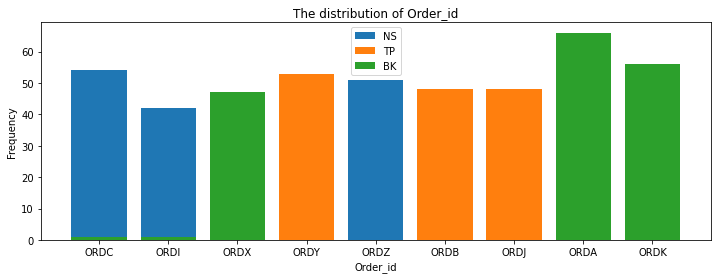

In [33]:
# plot bar chart to examine the distribution of order_id
plt.figure(figsize=(12,4))
for each in (ns_id, tp_id, bk_id):
    plt.bar([get_key(element) for element in each], [get_value(element) for element in each])
plt.title("The distribution of Order_id")
plt.xlabel("Order_id")
plt.ylabel("Frequency")
plt.legend(["NS", "TP", "BK"])
plt.show()

From the bar chart, the relationship between order_id and branch is clear. The result is:

- NS: ORDC, ORDI, ORDZ
- TP: ORDY, ORDB, ORDJ
- BK: ORDX, ORDA, ORDK

In [34]:
# build a dictionary for collecting order_id set
id_map = {
    "NS": {"ORDC", "ORDI", "ORDZ"},
    "TP": {"ORDY", "ORDB", "ORDJ"},
    "BK": {"ORDX", "ORDA", "ORDK"}
}

Therefore, the alphabets part of order_id is related to the branch. So, find the correct branch and fix them.

```python
    def fix_branch_code(self):
        is_changed = False
        # fix the uppercase and lowercase issue first
        branch_code_replace_map = {'tp':'TP', 'ns':'NS', 'bk':'BK'}
        if self.branch_code in branch_code_replace_map:
            self.branch_code = branch_code_replace_map[self.branch_code]
            is_changed = True
        # find correct branch from order_id
        correct_branch = self.find_branch_code()
        if self.branch_code != correct_branch:
            self.branch_code = correct_branch
            is_changed = True
        # if the branch code is fixed, re-find the branch node
        if is_changed:
            self.branch_node = self.find_branch_node()
        return self
    
    # from the order_id to find correct branch code
    def find_branch_code(self):
        id_head = self.order_id[:4]
        for branch, id_set in id_map.items():
            if id_head in id_set:
                return branch
```

In [35]:
for data_eg in dirty_data_list:
    if data_eg.branch_code in ('tp', 'bk', 'ns'):
        break
        
print(data_eg.branch_code)
data_eg.fix_branch_code()
print(data_eg.branch_code)

ns
TP


In [36]:
# as there is a object has been fixed in the previous chunk
count = 1
for data_eg in dirty_data_list:
    original = data_eg.branch_code
    data_eg.fix_branch_code()
    if original != data_eg.branch_code:
        count += 1
count

37

Therefore, there are 37 errors of branch_code in dirty data

### 4.4.4 Fix order_items and order_prices

#### Fix order_items

To find the menus for each order_type, it is necessary to divide them by their order type.

In [37]:
# classify orders by different order types
breakfast_orders = [each for each in dirty_data_list if each.order_type == "Breakfast"]
lunch_orders = [each for each in dirty_data_list if each.order_type == "Lunch"]
dinner_orders = [each for each in dirty_data_list if each.order_type == "Dinner"]
error_orders = [each for each in dirty_data_list if each.order_type == "Error"]

# count each type, and examine if there is errors inside
print(len(breakfast_orders), len(lunch_orders), len(dinner_orders), len(error_orders))

169 180 153 0


In [38]:
# extract order_item for each Breakfast order
nested_order_items = list(map(DirtyData.get_order_items, breakfast_orders))
nested_order_items[:5]

[[('Pancake', 6), ('Coffee', 3), ('Cereal', 6), ('Eggs', 5)],
 [('Coffee', 2), ('Pancake', 10), ('Eggs', 9)],
 [('Pancake', 6), ('Coffee', 7), ('Cereal', 2)],
 [('Eggs', 4), ('Coffee', 7)],
 [('Eggs', 7), ('Pancake', 3)]]

In [39]:
# define the function for transforming list to flat
def to_flat(list_1, list_2):
    return list_1 + list_2

flat_order_items = reduce(to_flat, nested_order_items)
flat_order_items[:8]

[('Pancake', 6),
 ('Coffee', 3),
 ('Cereal', 6),
 ('Eggs', 5),
 ('Coffee', 2),
 ('Pancake', 10),
 ('Eggs', 9),
 ('Pancake', 6)]

Apply the function `reduce_by_key()` to count each dish for breakfast menu.

In [40]:
# get the distribution of items for breakfast
list(reduce_by_key(lambda x,y: x+y, flat_order_items))

[('Burger', 7),
 ('Cereal', 649),
 ('Chicken', 8),
 ('Coffee', 626),
 ('Eggs', 725),
 ('Fish&Chips', 18),
 ('Fries', 5),
 ('Pancake', 682),
 ('Pasta', 6),
 ('Salad', 13),
 ('Shrimp', 9),
 ('Steak', 19)]

From the output, there are huge difference of the quantity of "Cereal", "Coffee", "Eggs" and "Pancake" to others, which means the items with tiny quantity are the error in the dirty data. 

In [41]:
# define the function to get item distributions for given orders
def get_sum_order_times(order_list):
    nested_order_items = list(map(DirtyData.get_order_items, order_list))
    flat_order_items = reduce(to_flat, nested_order_items)
    return list(reduce_by_key(lambda x,y: x+y, flat_order_items))

# define the function to generate bar chart
def generate_bars_from_order_lists(order_list):
    sum_orders = get_sum_order_times(order_list)
    print(sum_orders)
    keys = [each[0] for each in sum_orders]
    values = [each[1] for each in sum_orders]
    # plot
    plt.bar(keys, values)

[('Burger', 7), ('Cereal', 649), ('Chicken', 8), ('Coffee', 626), ('Eggs', 725), ('Fish&Chips', 18), ('Fries', 5), ('Pancake', 682), ('Pasta', 6), ('Salad', 13), ('Shrimp', 9), ('Steak', 19)]
[('Burger', 637), ('Chicken', 628), ('Coffee', 9), ('Eggs', 18), ('Fish&Chips', 1), ('Fries', 677), ('Pancake', 16), ('Pasta', 4), ('Salad', 707), ('Salmon', 2), ('Shrimp', 10), ('Steak', 586)]
[('Burger', 17), ('Cereal', 9), ('Chicken', 2), ('Coffee', 17), ('Eggs', 24), ('Fish&Chips', 647), ('Fries', 4), ('Pancake', 3), ('Pasta', 647), ('Salmon', 643), ('Shrimp', 531), ('Steak', 6)]


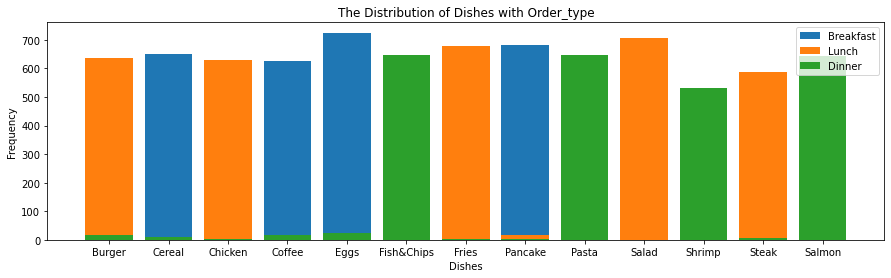

In [42]:
# plot
plt.figure(figsize=(15,4))
generate_bars_from_order_lists(breakfast_orders)
generate_bars_from_order_lists(lunch_orders)
generate_bars_from_order_lists(dinner_orders)
plt.title("The Distribution of Dishes with Order_type")
plt.legend(["Breakfast", "Lunch", "Dinner"])
plt.xlabel("Dishes")
plt.ylabel("Frequency")
plt.show()

From the plot, the result is:

- Breakfast: Cereal, Coffee, Eggs, Pancake
- Lunch: Burger, Chicken, Fries, Salad, Steak
- Dinner: Fish&Chips, Pasta, Shrimp, Salmon

In [43]:
# build the constant variables to represent menus
BREAKFAST_MENU = ["Cereal", "Coffee", "Eggs", "Pancake"]
LUNCH_MENU = ["Burger", "Chicken", "Fries", "Salad", "Steak"]
DINNER_MENU = ["Fish&Chips", "Pasta", "Shrimp", "Salmon"]

Then, calculate the each price for each dish by `numpy.linalg`. (Numpy, 2019)

In [44]:
# build the copy for further calculation
dirty_data_2 = dirty_data_list.copy()
breakfast_orders_2 = [each for each in dirty_data_list if each.order_type == "Breakfast"]
lunch_orders_2 = [each for each in dirty_data_list if each.order_type == "Lunch"]
dinner_orders_2 = [each for each in dirty_data_list if each.order_type == "Dinner"]

def solve_equations_from_orders(order_list, n, loyalty=False):
    order_list.sort(key=lambda x: len(x.order_items), reverse=True)
    # define the function to filter the orders with correct order items
    correct_menu_map = {
        "Breakfast": BREAKFAST_MENU,
        "Lunch": LUNCH_MENU,
        "Dinner": DINNER_MENU
    }
    def get_equations_amount_needed(order):
        return len(correct_menu_map[order.order_type])
    
    # filter the orders which contains correct order items
    new_order_list = []
    correct_menu = correct_menu_map[order_list[0].order_type]
    for each in order_list:
        if each.customerHasloyalty == loyalty:
            for item, quantity in each.order_items:
                if item not in correct_menu:
                    break
            else:
                new_order_list.append(each)
    
    # get data for build the equations
    equations_amount_needed = get_equations_amount_needed(new_order_list[0])
    orders_for_equations = new_order_list[n:n+equations_amount_needed]
    
    # build numpy arrays as preparation of solving the equations (ax=b)
    a = np.asarray([[0] * equations_amount_needed] * equations_amount_needed)
    b = np.asarray([float(0)] * equations_amount_needed)
    
    # fill values to the numpy arrays
    for index1 in range(len(orders_for_equations)):
        order = orders_for_equations[index1]
        for item, quantity in order.order_items:
            index2 = correct_menu.index(item)
            a[index1][index2] = quantity
        b[index1] = order.order_price
    
    # use solve function in numpy to get solution
    return np.linalg.solve(a, b)

Then, apply these functions to get dish prices.

In [45]:
# define the function to get final price for each dishes
def get_price_of_dishes(order_list, loyalty=False):
    result = generate_solutions(order_list)
    result = list(map(lambda x: round(x, 2), result))
    return result

# generate final result by calculating mode of 50 tries
def generate_solutions(order_list, loyalty=False):
    i = 50
    while True:
        collection = []
        for n in range(i):
            collection.append(str(solve_equations_from_orders(order_list, n, loyalty).tolist()))
        try:
            result = eval(mode(collection))
            break
        except:
            i += 10
    return result


breakfast_correct_price = get_price_of_dishes(breakfast_orders_2)
lunch_correct_price = get_price_of_dishes(lunch_orders_2)
dinner_coorect_price = get_price_of_dishes(dinner_orders_2)

print(breakfast_correct_price)
print(lunch_correct_price)
print(dinner_coorect_price)

[21.0, 7.5, 22.0, 24.25]
[31.0, 32.0, 12.0, 17.2, 45.0]
[35.0, 27.5, 54.0, 41.0]


Combine these dish prices to the menus to get menus with prices.

In [46]:
# build dictionary for menu in breakfast, lunch and dinner
BREAKFAST_PRICE = dict(zip(BREAKFAST_MENU, breakfast_correct_price))
LUNCH_PRICE = dict(zip(LUNCH_MENU, lunch_correct_price))
DINNER_PRICE = dict(zip(DINNER_MENU, dinner_coorect_price))

print(BREAKFAST_PRICE)
print(LUNCH_PRICE)
print(DINNER_PRICE)

{'Cereal': 21.0, 'Coffee': 7.5, 'Eggs': 22.0, 'Pancake': 24.25}
{'Burger': 31.0, 'Chicken': 32.0, 'Fries': 12.0, 'Salad': 17.2, 'Steak': 45.0}
{'Fish&Chips': 35.0, 'Pasta': 27.5, 'Shrimp': 54.0, 'Salmon': 41.0}


Then, define the method in `DirtyData` class to fix the wrong order items.

```python
    def fix_order_items(self):
        correct_menu_map = {
            "Breakfast": BREAKFAST_PRICE,
            "Lunch": LUNCH_PRICE,
            "Dinner": DINNER_PRICE
        }
        is_correct = True
        correct_price = correct_menu_map[self.order_type]
        # check if there is wrong item in the order_items
        for item, quantity in self.order_items:
            if item not in correct_price:
                is_correct = False
                break
        # if the order_items is correct, do nothing
        if is_correct:
            return self
        # else fix the wrong item
        else:
            new_order_items = self.order_items.copy()
            # initialize the price variable for calculation
            price = self.order_price
            # minus all correct item prices
            for item, quantity in self.order_items:
                if item in correct_price:
                    price -= correct_price[item] * quantity
            # get the wrong item and index
            wrong_pair = list(filter(lambda x: x[0] not in correct_price.keys(), self.order_items))[0]
            wrong_index = new_order_items.index(wrong_pair)
            # calculate the correct price for the wrong item
            correct_item_price = price / wrong_pair[1]
            # find the correct item from menu
            for menu_item, menu_price in correct_price.items():
                if menu_price == correct_item_price:
                    correct_item = menu_item
                    break
            # modify the wrong pair to correct one
            new_order_items[wrong_index] = (correct_item, wrong_pair[1])
            self.order_items = new_order_items
            return self
```

Apply the `fix_order_items()` method, and display the change in an example. 

In [47]:
for each in dirty_data_list:
    if each.order_items == [('Eggs', 3), ('Salad', 5)]:
        data_eg = each
        break

print(data_eg.order_items)
# print(data_eg)
data_eg.fix_order_items()
print(data_eg.order_items)

[('Eggs', 3), ('Salad', 5)]
[('Eggs', 3), ('Cereal', 5)]


According to the output, the order_items is fixed correctly. 

Then, apply the method to all dirty data, and count the objects with wrong order_items.

In [48]:
count = 1
# apply the fix method for all dirty data
for each in dirty_data_list:
    original = each.order_items
    each.fix_order_items()
    if original != each.order_items:
        count += 1
    
print(count)

37


From the output, there are 37 dirty data with wrong order_items.

Then, check the dish distribution in 3 different order_type after fixing them.

In [49]:
print(get_sum_order_times(breakfast_orders))
print(get_sum_order_times(lunch_orders))
print(get_sum_order_times(dinner_orders))

[('Cereal', 660), ('Coffee', 635), ('Eggs', 746), ('Pancake', 726)]
[('Burger', 648), ('Chicken', 638), ('Fries', 697), ('Salad', 707), ('Steak', 605)]
[('Fish&Chips', 664), ('Pasta', 665), ('Salmon', 663), ('Shrimp', 558)]


#### Fix order_price

After getting the price of each item (4.4.4), it is necessary to caculate the totle order_price and fix the errors.

<b>Menu</b>
- {'Cereal': 21.0, 'Coffee': 7.5, 'Eggs': 22.0, 'Pancake': 24.25}
- {'Burger': 31.0, 'Chicken': 32.0, 'Fries': 12.0, 'Salad': 17.2, 'Steak': 45.0}
- {'Fish&Chips': 35.0, 'Pasta': 27.5, 'Shrimp': 54.0, 'Salmon': 41.0}

Firstly, the order_type is identified which is used to find the related menu in the `correct_menu_map`.
Secondly, caculaing the total price.
Finally, if the price is not equal to the original order-price, the order_price should be fixed.

```python
    def fix_order_price(self):
        # calculate the correct price from the correct order_items
        # fix the order_price if it is not equal
        correct_menu_map = {
            "Breakfast": BREAKFAST_PRICE,
            "Lunch": LUNCH_PRICE,
            "Dinner": DINNER_PRICE
        }
        correct_price = correct_menu_map[self.order_type]
        price = 0
        for item, quantity in self.order_items:
            price += correct_price[item] * quantity
        price = round(price, 2)

        if price != self.order_price:
            self.order_price = price
        return self
```

#### Example

Apply the functions to the compare the price before and after fixing, and count the errors about orders price in dirty data.

In [50]:
for data_eg in dirty_data_list:
    if data_eg.order_id == "ORDY00755":
        print(data_eg.order_items)
        print(data_eg.order_price)
        break

count = 0
for each in dirty_data_list:
    original = each.order_price
    each.fix_order_price()
    if original != each.order_price:
        count += 1

print(data_eg.order_price)

print(count)

[('Salad', 10), ('Steak', 9), ('Fries', 10), ('Burger', 5), ('Chicken', 7)]
591.8
1076.0
37


From the output, the wrong value has been changed correctly, and the amount of error about price is **37**.

### 4.4.5 Fix location and distance_to_customer_KM

The following method is defined in DirtyData class which will help us to identify the wrong lon and lat infomation which cannot be found in the node_list.
```python
def display_loc(self):
        # display customer location node
        return f"Node {self.node} in ({self.customer_lat}, {self.customer_lon})"
```    
<b>In this part if the lat and lon cannot be found in the the node_list, the self.node will be `None` which means the information has errors</b>
```python   
# define the dirty data class for manipulating the dirty data
class DirtyData(Data):
    def __init__(self, *args):
        Data.__init__(self, *args)
        self.node = self.find_node()
        self.branch_node = self.find_branch_node()
        dirty_data_list.append(self)
```
<b>The following method is from Data class which is called in above DirtyData class</b>
```python
    def find_node(self):
        for node in Node.node_list:
            if node.lat == self.customer_lat and node.lon == self.customer_lon:
                return node.node_id
```



In [51]:
for each in dirty_data_list[:20]:
    print(each.display_loc())

Node 777841688.0 in (-37.8018052, 144.9571189)
Node 1224869086.0 in (-37.8137302, 144.9409476)
Node None in (37.8050314, 144.9279056)
Node 4520380539.0 in (-37.817582, 144.9590952)
Node 4520380518.0 in (-37.8116841, 144.956303)
Node 2700682445.0 in (-37.8241121, 144.9771169)
Node 4157116154.0 in (-37.8179027, 144.993605)
Node 4518401170.0 in (-37.807837, 144.9494312)
Node None in (37.8125792, 144.9690115)
Node 1132014870.0 in (-37.817823, 144.9462511)
Node 1879206771.0 in (-37.8003819, 144.9608832)
Node 3146808099.0 in (-37.8101959, 144.9822571)
Node 2174950789.0 in (-37.8161096, 144.9527874)
Node None in (37.8009468, 144.9685286)
Node 664379624.0 in (-37.8209865, 144.9660368)
Node 2174963258.0 in (-37.8172872, 144.9533263)
Node 6167489494.0 in (-37.8179449, 144.9621622)
Node 1594632456.0 in (-37.8203616, 144.979064)
Node 296038801.0 in (-37.8085482, 144.9556474)
Node 257506017.0 in (-37.7991307, 144.9634187)


<b>Some customers cannot find a related node. Filter the fail data to examine them.</b>

In [52]:
unmatched_loc = [each for each in dirty_data_list if each.node is None]
matched_loc = [each for each in dirty_data_list if each.node is not None]

In [53]:
len(unmatched_loc)

41

There are 41 orders in dirty data have errors with location values.

<b>By analysising the ummatched_loc and mateched_loc, we find that there are two types error.</b>
1. the latitude without negative sign
2. the longitude should be about 144

In [54]:
[each.display_loc() for each in unmatched_loc][:10]

['Node None in (37.8050314, 144.9279056)',
 'Node None in (37.8125792, 144.9690115)',
 'Node None in (37.8009468, 144.9685286)',
 'Node None in (37.8159539, 144.9865358)',
 'Node None in (37.8155917, 145.0059186)',
 'Node None in (37.8196941, 144.9708975)',
 'Node None in (37.811785, 144.9887435)',
 'Node None in (37.7994961, 144.9491927)',
 'Node None in (37.8162688, 144.9563044)',
 'Node None in (37.8196813, 144.9810997)']

In [55]:
[each.display_loc() for each in matched_loc][:10]

['Node 777841688.0 in (-37.8018052, 144.9571189)',
 'Node 1224869086.0 in (-37.8137302, 144.9409476)',
 'Node 4520380539.0 in (-37.817582, 144.9590952)',
 'Node 4520380518.0 in (-37.8116841, 144.956303)',
 'Node 2700682445.0 in (-37.8241121, 144.9771169)',
 'Node 4157116154.0 in (-37.8179027, 144.993605)',
 'Node 4518401170.0 in (-37.807837, 144.9494312)',
 'Node 1132014870.0 in (-37.817823, 144.9462511)',
 'Node 1879206771.0 in (-37.8003819, 144.9608832)',
 'Node 3146808099.0 in (-37.8101959, 144.9822571)']

According to the correct location data, the lat value should be around `-37` and the lon value should be around `144`. From Latitudelongitude.org(2019), this location is in Melbourne city, Victoria. Therefore, the Melbourne is the service range of this restaurant.

However, from the `unmatched_loc`, there are 2 types of error. One of them is that the lat and lon values located in opposite place, like `(145.0019104, -37.8020948)`, change the position can fix the error.

Another error is that the lat value miswritten without negative sign `-` like `(37.8003595, 144.9606992)`. The method to fix it is to add the negative sign.

```python
    def fix_location(self):
        if 30 < self.customer_lat < 40:
            # if the error is the negative sign
            self.customer_lat = self.customer_lat * (-1)
            self.node = self.find_node()
            return self
        elif self.customer_lat > 100 and self.customer_lon < 0:
            # if the error is the opposite places of lat and lon values
            self.customer_lat, self.customer_lon = self.customer_lon, self.customer_lat
            self.node = self.find_node()
            return self
        else:
            # no fix for no error rows
            return self
```

After impletmenting the method, the errors found has been corrected. There are no None apper in the list, which means all of lon and lat has been fixed and find the related node bumber.

In [56]:
for each in dirty_data_list:
    each.fix_location()
    
[each.display_loc() for each in dirty_data_list][:10]

['Node 777841688.0 in (-37.8018052, 144.9571189)',
 'Node 1224869086.0 in (-37.8137302, 144.9409476)',
 'Node 581713855.0 in (-37.8050314, 144.9279056)',
 'Node 4520380539.0 in (-37.817582, 144.9590952)',
 'Node 4520380518.0 in (-37.8116841, 144.956303)',
 'Node 2700682445.0 in (-37.8241121, 144.9771169)',
 'Node 4157116154.0 in (-37.8179027, 144.993605)',
 'Node 4518401170.0 in (-37.807837, 144.9494312)',
 'Node 5015518502.0 in (-37.8125792, 144.9690115)',
 'Node 1132014870.0 in (-37.817823, 144.9462511)']

#### Creating Edges class for making graph

A `edges.csv` file which has all information related to the distance between each nodes is provided.
This is used in making graph.(networkx 2019)

In [57]:
# define the class to store the information from the data frame
class Edge:
    edge_list = []
    
    def __init__(self, u, v, distance, street_type, speed):
        self.u = u
        self.v = v
        self.distance = distance
        self.street_type = street_type
        self.speed = speed
        Edge.edge_list.append(self)
        
    @staticmethod
    def build_edge(row):
        u = row[1]
        v = row[2]
        distance = row[3]
        street_type = row[4]
        speed = row[5]
        return Edge(u, v, distance, street_type, speed)
    
    # define the method to transfer the instance to the format that networkx need
    def to_nx_edge(self):
        attr_dict = {
            "distance": self.distance,
            "street_type": self.street_type,
            "speed": self.speed
        }
        return self.u, self.v, attr_dict

In [58]:
edge_data = pd.read_csv("edges.csv")
for row in edge_data.values:
    Edge.build_edge(row)
    
nx_edge_list = [edge.to_nx_edge() for edge in Edge.edge_list]

In [59]:
nx_edge_list[:5]

[(711327755.0,
  711332946.0,
  {'distance': 58.0, 'street_type': 1.0, 'speed': 15.0}),
 (711327755.0,
  55725841.0,
  {'distance': 15.0, 'street_type': 2.0, 'speed': 20.0}),
 (711327755.0,
  711327760.0,
  {'distance': 165.0, 'street_type': 1.0, 'speed': 15.0}),
 (711327756.0,
  703557073.0,
  {'distance': 4.0, 'street_type': 0.0, 'speed': 10.0}),
 (711327756.0,
  711332946.0,
  {'distance': 8.0, 'street_type': 1.0, 'speed': 15.0})]

Besides the edges, all of nodes are also needed when a graph is built (networkx 2019).

In [60]:
# build the list for node for the format of networkx
nx_node_list = [node.node_id for node in Node.node_list]
nx_node_list[:5]

[711327755.0, 711327756.0, 711327759.0, 711327760.0, 777781264.0]

According to networkx(2019), firstly, a graph need to be created and then given all nodes to this graph. Finally, add edges between nodes.

In [61]:
# build graph
graph = nx.Graph()
graph.add_nodes_from(nx_node_list)
graph.add_edges_from(nx_edge_list)

After creating the graph,the dijkstra algorithm can be used to caculate the distance between the branch_nodes and the customer_nodes. If the result of the caculation is different from the original distance, it need to be fixed. Therefore, the following function is defined.
```python
    def fix_distance(self):
        # calculate the distance by dijkstra algorithm
        distance = dijkstra_path_length(G=graph, source=self.branch_node, target=self.node, weight="distance")
        # transfer m to km
        distance /= 1000
        if distance != self.distance_to_customer_KM:
            self.distance_to_customer_KM = distance
        return self
```

#### Example

Find an example to display if the function is available to apply, and count the errors with distance in dirty data.

In [62]:
# apply the function to the example to examine if it works
cust_eg = dirty_data_list[3]
print(cust_eg.distance_to_customer_KM)

# count the number of dirty data that has been fixed
count = 0
for each in tqdm(dirty_data_list):
    original = each.distance_to_customer_KM 
    each.fix_distance()
    if each.distance_to_customer_KM != original:
        count += 1
print(cust_eg.distance_to_customer_KM)
print(count)

9.053


  0%|          | 0/502 [00:00<?, ?it/s]

7.947
37


The wrong distance $9.053$ has been fixed to $7.947$, which means the function works well. Besides, there are 37 errors in the dirty data about distance.

# 5. Outlier Data

## 5.1 Load and Examine Outlier Data 

First of all, it is necessary to examine data in the csv. Therefore, create a data frame for further manipulation.

In [63]:
outlier_data = pd.read_csv("outlier_data.csv")
outlier_data.head(3)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDZ03067,2018-04-20,11:32:57,Breakfast,NS,"[('Cereal', 7), ('Eggs', 9), ('Pancake', 9)]",563.25,-37.802328,144.943526,0,8.776,13.779540
1,ORDY01809,2018-08-02,15:05:54,Lunch,TP,"[('Steak', 5), ('Chicken', 1), ('Fries', 6), (...",411.60,-37.808548,144.955647,0,9.024,11.548702
2,ORDJ10913,2018-12-30,20:00:00,Dinner,TP,"[('Shrimp', 4), ('Salmon', 6), ('Pasta', 2)]",517.00,-37.799989,145.009386,0,12.970,17.985392


As the format of outlier data is same to dirty data, implementing a OutlierData class to inherit `Data` class which is defined in 4.3.1 is benefit to wrangle the data.

For the method in class OutlierData:
 - build_data_from_row(): a static method to build OutlierData object from a row in data frame
 - recognize_outlier(): a method for recognizing the data is outlier or not, will be mentioned in 5.2
 - fix_outlier(): a method for filter the data which is not outlier, will be mentioned in 5.2

In [64]:
class OutlierData(Data):
    def __init__(self, *args):
        Data.__init__(self, *args)
        self.is_outlier = False
    
    @staticmethod
    def build_data_from_row(row: Series):
        values = extract_values_from_row(row)
        return OutlierData(*values)
        
    def recognize_outlier(self):
        lower_limit, upper_limit = boundaries[self.branch_code].get_boundary()
        linear_model = lm_models[self.branch_code]
        diff = linear_model.predict([self.features])[0] - self.fee
        if diff < lower_limit or diff > upper_limit:
            self.is_outlier = True
        return self
    
    @staticmethod
    def fix_outliers(data_list):
        new_list = [each for each in data_list if not each.is_outlier]
        return new_list

## 5.2 Fix the Outlier Data

It is known that the loyalty will provide a 50% discount to delivery fee. The actual delivery fee without discount depends **linearly** to 3 attibutes below:
 - weekend or weekday (1 or 0)
 - time of the day (morning 0, afternoon 1, evening 2)
 - distance between the customer and the branch
 
Also, 3 branches have 3 different way to calculate the delivery fee, which means the linear model in 3 branches are different. Therefore, the data should be devided by their branch code.

In [65]:
outlier_data_list = []
for row in outlier_data.values:
    outlier_data_list.append(OutlierData.build_data_from_row(row))
    
# devide
ns_outlier_data_list = [each for each in outlier_data_list if each.branch_code == "NS"]
tp_outlier_data_list = [each for each in outlier_data_list if each.branch_code == "TP"]
bk_outlier_data_list = [each for each in outlier_data_list if each.branch_code == "BK"]
ns_outlier_data_list[:3]

[OutlierData(order_id='ORDZ03067', date='2018-04-20', time='11:32:57', order_type='Breakfast', branch_code='NS', order_items=[('Cereal', 7), ('Eggs', 9), ('Pancake', 9)], order_price=563.25, customer_lat=-37.8023282, customer_lon=144.9435265, customerHasloyalty=0, distance_to_customer_KM=8.776, delivery_fee=13.77954),
 OutlierData(order_id='ORDI09796', date='2018-04-21', time='11:32:57', order_type='Breakfast', branch_code='NS', order_items=[('Coffee', 2), ('Eggs', 2), ('Cereal', 2)], order_price=101.0, customer_lat=-37.8188654, customer_lon=144.9539685, customerHasloyalty=0, distance_to_customer_KM=9.176, delivery_fee=16.6501548),
 OutlierData(order_id='ORDZ07879', date='2018-07-04', time='14:05:04', order_type='Lunch', branch_code='NS', order_items=[('Salad', 10), ('Fries', 8)], order_price=268.0, customer_lat=-37.8034919, customer_lon=144.9665299, customerHasloyalty=0, distance_to_customer_KM=6.72, delivery_fee=12.2972)]

As the delivery fee is linearly depended by these 3 features. Define some methods as preparation for fitting linear model in class Data because the features also need to be used in fixing dirty data.
```python
    # define the day for calculate the linear model
    @property
    def day(self):
        # Monday is 0 and Sunday is 6
        return datetime.strptime(self.date, "%Y-%m-%d").date().weekday()
    
    # define the function to create a feature vector for fitting linear model
    @property
    def features(self):
        time_map = {
            "Breakfast": 0,
            "Lunch": 1,
            "Dinner": 2
        }
        # if day is weekday, day_feature is 0;
        # if day is weekend, day_feature is 1
        day_feature = 0 if self.day <= 4 else 1
        time_feature = time_map[self.order_type]
        distance_feature = self.distance_to_customer_KM
        return day_feature, time_feature, distance_feature
    
    @property
    def fee(self):
        if self.customerHasloyalty:
            return self.delivery_fee * 2
        else:
            return self.delivery_fee
```

To find the multi-variable outliers in the dataset, calculating the outlier of the differences between predicted delivery fee and actual delivery fee is a reasonable choice.

Therefore, implement the functions to generate the difference values for each data object, and find the linear model and outlier boundary.

In [66]:
def generate_diff_and_linear_model(data_list: List, t=1.5):
    # this function can generate the linear model and the difference values from
    # the list containing data objects
    
    # extract features and delivery_fees from the data objects
    features_list = [each.features for each in data_list]
    y_list = [each.fee for each in data_list]
    branch = data_list[0].branch_code
    
    # fit the linear model from the feature vectors and the fees
    lm = LinearRegression()
    lm.fit(features_list, y_list)
    
    # calculate the difference value and outlier boundary
    diff = lm.predict(features_list) - y_list
    inside, outlier, boundary = count_outliers(diff, t)
    
    # define a inner class to wrap the information to return
    class LinearModelInfo:
        def __init__(self, diff, lm, inside, outlier, branch, boundary):
            self.diff = diff
            self.lm = lm
            self.inside = inside
            self.outlier = outlier
            self.branch = branch
            self.boundary = boundary
            self.display()
            
        def display(self):
            print(f"The amount of outliers in {self.branch} is {self.outlier}")

    return LinearModelInfo(diff, lm, inside, outlier, branch, boundary)

def calculate_outlier_boundary(nums, t):
    # this function is used to calculate the upper and lower limit for recognizing outliers
    # calculate the first quartile and third quartile
    q1 = np.percentile(nums, 25)
    q3 = np.percentile(nums, 75)
    # calculate the upper and lower boundary
    iqr = q3 - q1
    upper_boundary = q3 + t * iqr
    lower_boundary = q1 - t * iqr
    
    # define a inner class to wrap the boundary info
    class Boundary:
        def __init__(self, lower, upper):
            self.lower = lower
            self.upper = upper
        
        def get_boundary(self):
            return self.lower, self.upper
        
    return Boundary(lower_boundary, upper_boundary)

def count_outliers(nums, t):
    # this function is defined to count the amount of outliers
    boundary = calculate_outlier_boundary(nums, t)
    lower_boundary, upper_boundary = boundary.get_boundary()
    inside = 0
    outlier = 0
    for each in nums:
        if lower_boundary <= each <= upper_boundary:
            inside += 1
        else:
            outlier += 1
    return inside, outlier, boundary


Then, apply the functions defined in previous.

The amount of outliers in NS is 14
The amount of outliers in TP is 15
The amount of outliers in BK is 15


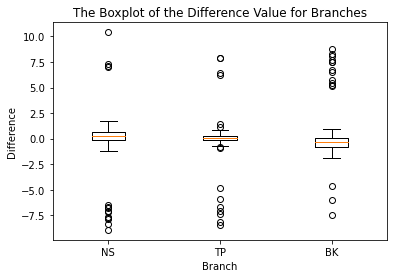

In [67]:
ns, tp, bk = [generate_diff_and_linear_model(each) for each in [ns_outlier_data_list, tp_outlier_data_list, bk_outlier_data_list]]

lm_models = {"NS": ns.lm, "TP": tp.lm, "BK": bk.lm}
boundaries = {"NS": ns.boundary, "TP": tp.boundary, "BK": bk.boundary}
boxplot_data = [ns.diff, tp.diff, bk.diff]

# plot
plt.boxplot(boxplot_data, labels=["NS", "TP", "BK"])
plt.title("The Boxplot of the Difference Value for Branches")
plt.xlabel("Branch")
plt.ylabel("Difference")
plt.show()

From the boxplot output, it is clearly that the NS and BK has recognized correct outliers but TP does not. There are still some points around the boundary and can be considered as not outlier points. Therefore, increase the $t = 3$ to fit the outliers.

The amount of outliers in NS is 14
The amount of outliers in TP is 11
The amount of outliers in BK is 15


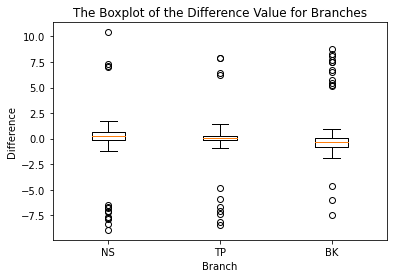

In [68]:
t = 3
ns, tp, bk = [generate_diff_and_linear_model(each, t) for each in [ns_outlier_data_list, tp_outlier_data_list, bk_outlier_data_list]]

lm_models = {"NS": ns.lm, "TP": tp.lm, "BK": bk.lm}
boundaries = {"NS": ns.boundary, "TP": tp.boundary, "BK": bk.boundary}

boxplot_data = [ns.diff, tp.diff, bk.diff]

plt.boxplot(boxplot_data, labels=["NS", "TP", "BK"], whis=t)
plt.title("The Boxplot of the Difference Value for Branches")
plt.xlabel("Branch")
plt.ylabel("Difference")
plt.show()

From the boxplot, there are big gaps between outliers and normal values, so this theory performs well.

Define the methods in OutlierData class for further manipulating the OutlierData objects.

```python
    def recognize_outlier(self):
        lower_limit, upper_limit = boundaries[self.branch_code].get_boundary()
        linear_model = lm_models[self.branch_code]
        diff = linear_model.predict([self.features])[0] - self.fee
        if diff > upper_limit or diff < lower_limit:
            self.is_outlier = True
        return self
    
    @staticmethod
    def fix_outliers(data_list):
        new_list = [each for each in data_list if not each.is_outlier]
        return new_list
```

In [69]:
# apply the methods to all outlier data
for each in outlier_data_list:
    each.recognize_outlier()
outlier_data_list = OutlierData.fix_outliers(outlier_data_list)
len(outlier_data_list)

460

Therefore, there are 40 outliers has been removed.

After calculating the linear models for each branch. It is necessary to review the dirty data to fix the loyalty information.

### 5.2.1 Fix customerHasloyalty for Dirty Data

Use the linear model fitted in previous to predict delivery fee. As the loyalty discount is 50% off, the ratio of predicted fee and actual delivery fee can be used to classify the customer is loyalty or not in dirty data.

In [70]:
def calculate_delivery_fee(data):
    lm = lm_models[data.branch_code]
    predicted = lm.predict([data.features])[0]
    return predicted / data.delivery_fee
    
for each in dirty_data_list[:10]:
    print(each.customerHasloyalty, calculate_delivery_fee(each))

0 0.9775065054435343
1 1.95293860610251
0 1.0017515763779434
0 1.0169745038800426
0 0.9533693541745336
0 1.020417884491464
0 0.9637358011672843
0 1.0447605378424334
0 0.9734876569847547
0 1.018598428245178


From the output, if the ratio of predicted fee and actual delivery fee is closed to 2, it means there is loyalty discount implemented; if the ratio is closed to 1, which means there is no discount.

Therefore, implement the code to fix the loyalty of dirty data.
```python
    def fix_customerHasloyalty(self):
        predicted_loyalty = predict_loyalty(self)
        if self.customerHasloyalty != predicted_loyalty:
            self.customerHasloyalty = predicted_loyalty
        return self
```

Implemting the function `predict_loyalty()` is to predict if the customer has loyalty.

In [71]:
def predict_loyalty(data):
    ratio = calculate_delivery_fee(data)
    # if the ratio is closed to 2
    if ratio >= 1.5:
        predicted_loyalty = 1
    else:
        predicted_loyalty = 0
    return predicted_loyalty

# apply the functions defined in previous to all dirty data
# and count the wrong loyalty data
count = 0
for each in dirty_data_list:
    original = each.customerHasloyalty
    each.fix_customerHasloyalty()
    if each.customerHasloyalty != original:
        count += 1
    
count

37

# 6. Missing Data

## 6.1 Load and Examine Missing Data

To find the missing value information in missing dataset, it is necessary to count the missing value in each columns.

In [72]:
# load missing data from csv file
missing_data = pd.read_csv("missing_data.csv")
missing_data.head(3)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDZ02595,2018-12-28,20:00:00,Dinner,NS,"[('Salmon', 6), ('Pasta', 7)]",438.5,-37.812098,144.970671,0,7.418,13.295550
1,ORDY05662,2018-09-23,16:47:19,Dinner,TP,"[('Pasta', 10), ('Shrimp', 1), ('Salmon', 8), ...",832.0,-37.805998,144.955946,0,9.277,14.591742
2,ORDY11043,2018-09-05,16:06:45,Dinner,NaN,"[('Shrimp', 1), ('Salmon', 6), ('Pasta', 7), (...",702.5,-37.815245,144.927660,0,11.747,15.731445


In [73]:
# count missing value
missing_data.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                50
dtype: int64

## 6.2 Fix the Missing Data

From the output, it is clearly that there are missing values in `branch_code`, `distance_to_customer_KM` and `delivery_fee`.

Implement a MissingData class inheritancing Data class to store the missing data, and define these methods to fix the missing data.
 - fix_branch_code()
 - fix_distance()
 - fix_delivery_fee()

In [74]:
missing_data_list = []
# define the missing data class to manipulate the data in missing data
class MissingData(Data):
    def __init__(self, *values):
        Data.__init__(self, *values)
        self.node = self.find_node()
        self.branch_node = self.find_branch_node()
        missing_data_list.append(self)
        
    @staticmethod
    def build_data_from_row(row: Series):
        values = extract_values_from_row(row)
        return MissingData(*values)
    
    def fix_branch_code(self):
        # if the branch code is missing
        if type(self.branch_code) is not str:
            self.branch_code = self.find_branch_code()
            self.branch_node = self.find_branch_node()
        return self
        
    def fix_distance(self):
        # if the distance is missing
        if np.isnan(self.distance_to_customer_KM):
            # using dijkstra algorithm to find correct distance
            distance = dijkstra_path_length(G=graph, source=self.branch_node, target=self.node, weight="distance")
            distance /= 1000
            self.distance_to_customer_KM = round(distance, 3)
        return self
    
    def fix_delivery_fee(self):
        # if the delivery fee is missing
        if np.isnan(self.delivery_fee):
            # find the linear model for the branch
            lm = lm_models[self.branch_code]
            # calculate the predicted fee for given features
            predicted_fee = lm.predict([self.features])[0]
            if self.customerHasloyalty:
                predicted_fee /= 2
            self.delivery_fee = round(predicted_fee, 7)
        return self

Apply the methods and build Missing Data instances from data frame.

In [75]:
missing_data_list = []
for row in missing_data.values:
    MissingData.build_data_from_row(row)

missing_data_list[:3]

[MissingData(order_id='ORDZ02595', date='2018-12-28', time='20:00:00', order_type='Dinner', branch_code='NS', order_items=[('Salmon', 6), ('Pasta', 7)], order_price=438.5, customer_lat=-37.8120976, customer_lon=144.9706706, customerHasloyalty=0, distance_to_customer_KM=7.418, delivery_fee=13.2955496),
 MissingData(order_id='ORDY05662', date='2018-09-23', time='16:47:19', order_type='Dinner', branch_code='TP', order_items=[('Pasta', 10), ('Shrimp', 1), ('Salmon', 8), ('Fish&Chips', 5)], order_price=832.0, customer_lat=-37.8059977, customer_lon=144.9559457, customerHasloyalty=0, distance_to_customer_KM=9.277, delivery_fee=14.5917418),
 MissingData(order_id='ORDY11043', date='2018-09-05', time='16:06:45', order_type='Dinner', branch_code=nan, order_items=[('Shrimp', 1), ('Salmon', 6), ('Pasta', 7), ('Fish&Chips', 6)], order_price=702.5, customer_lat=-37.8152448, customer_lon=144.9276603, customerHasloyalty=0, distance_to_customer_KM=11.747, delivery_fee=15.7314455)]

In [76]:
# apply these method for each instance
for each in missing_data_list:
    each.fix_branch_code()
    each.fix_distance()
    each.fix_delivery_fee()

missing_data_matrix = [each.to_list() for each in missing_data_list]
new_missing_data = pd.DataFrame(missing_data_matrix, columns=Data.get_header())
new_missing_data.isnull().sum()

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
dtype: int64

From the output, it is clearly that all missing value has been fixed.

# 7. Output csv files
After defining all functions and classes used in previous, next step is to use these to process the data and output the csv files.
### 7.1 Dirty Data

In [77]:
def apply(x, func):
    return func(x)

# define the function to apply all methods in previous 
def fix_dirty_data(row):
    pipeline = [
        DirtyData.build_data_from_row,
        DirtyData.fix_date,
        DirtyData.fix_order_type,
        DirtyData.fix_branch_code,
        DirtyData.fix_order_items,
        DirtyData.fix_order_price,
        DirtyData.fix_location,
        DirtyData.fix_distance,
        DirtyData.fix_customerHasloyalty,
        DirtyData.to_list
    ]
    # apply the methods in pipeline to process the data
    return reduce(apply, [row] + pipeline)

# read data from csv file
dirty_data = pd.read_csv("dirty_data.csv")
# fix dirty data and generate 2d-list
new_dirty_data_matrix = [fix_dirty_data(row) for row in tqdm(dirty_data.values)]
# build data frame and output csv file
pd.DataFrame(new_dirty_data_matrix, columns=DirtyData.get_header()) \
    .to_csv("dirty_data_solution.csv", index=None)

  0%|          | 0/500 [00:00<?, ?it/s]

### 7.2 Outlier Data

In [78]:
def fix_outlier_data(row):
    return OutlierData.build_data_from_row(row).recognize_outlier()

# read outlier data from csv file
outlier_data = pd.read_csv("outlier_data.csv")
# recognize outlier data
outlier_data_list = [fix_outlier_data(row) for row in outlier_data.values]
# filter the data which is not outlier
outlier_data_list = OutlierData.fix_outliers(outlier_data_list)
# generate 2d-list
outlier_data_matrix = [OutlierData.to_list(each) for each in outlier_data_list]
# build data frame and output csv file
pd.DataFrame(outlier_data_matrix, columns=OutlierData.get_header()) \
    .to_csv("outlier_data_solution.csv", index=None)

### 7.3 Missing Data

In [79]:
def fix_missing_data(row):
    pipeline = [
        MissingData.build_data_from_row,
        MissingData.fix_branch_code,
        MissingData.fix_distance,
        MissingData.fix_delivery_fee,
        MissingData.to_list
    ]
    return reduce(apply, [row] + pipeline)

# read missing data from csv file
missing_data = pd.read_csv("missing_data.csv")
# fix missing data and generate 2d-list
new_missing_data_matrix = [fix_missing_data(row) for row in tqdm(missing_data.values)]
# build data frame and output csv file
pd.DataFrame(new_missing_data_matrix, columns=MissingData.get_header()) \
    .to_csv("missing_data_solution.csv", index=None)

  0%|          | 0/500 [00:00<?, ?it/s]

# 8 Summary
This project is aim to 
- detect and fix errors in dirty_data.csv
- Detect and remove outlier rows in outlier_data.csv (outliers are to be found w.r.t. delivery_fee attribute)
- Impute the missing values in missing_data.csv

The outcome achieved after using these basic techniques were:
1. <b>Detect and fix errors:</b> Using pandas to do EDA, using numpy.linalg to solve a liner system of equtions to fix the oder_items and using networkx to caculate the shotest path between two nodes.

2. <b>Detect and remove outlier:</b> Using sklearn library to fit sutiable liner model for each branch. Then, comparing the differences between the predict delievery fee and original delivery fee. Finally, using the difference to identify the outlier.

3. <b>Impute the missing values:</b> Inheritancing the Data class and using numpy to identify if the missing data is exist.


# 9. Reference

 1. Juanlu001. (2019). Python implementation of Spark reduceByKey(). Retrieved from https://gist.github.com/Juanlu001/562d1ec55be970403442
 2. Latitudelongitude.org. (2019). Melbourne latitude longitude. Retrieved from https://latitudelongitude.org/au/melbourne/
 3. networkx. (2019). networkx.algorithms.shortest_paths.weighted.dijkstra_path_length — NetworkX 2.4rc1.dev20191006044604 documentation. Retrieved from https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.dijkstra_path_length.html#networkx.algorithms.shortest_paths.weighted.dijkstra_path_length
 4. Numpy. (2019). Linear algebra (numpy.linalg) — NumPy v1.17 Manual. Retrieved from https://docs.scipy.org/doc/numpy/reference/routines.linalg.html
 5. Pyspark. (2019). pyspark package — PySpark 2.4.4 documentation. Retrieved from https://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=reduce%20key#pyspark.RDD.reduceByKey
 6. Python. (2019). dataclasses — Data Classes — Python 3.7.5rc1 documentation. Retrieved from https://docs.python.org/3/library/dataclasses.html
